In [1]:
from sklearn.metrics import confusion_matrix,accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import pylab as pl
import random
import math
import cv2
import os

# 2. Scene Recognition using Bag of Visual Words (BOVW)

In [2]:
num_clusters = 50
step_size = 10
regularisation_param = 0.5
def img_list(path):
    paths = [os.path.join(path,name) for name in os.listdir(path) if name!='.DS_Store']
    return paths

In [3]:
def plot_hist(test_features):
    x_scalar = np.arange(num_clusters)
    y_scalar = np.array([abs(np.sum(test_features[:,h], dtype=np.int32)) for h in range(num_clusters)])

    plt.bar(x_scalar, y_scalar)
    plt.xlabel("Visual Word Index")
    plt.ylabel("Frequency")
    plt.title("Complete Vocabulary Generated")
    plt.xticks(x_scalar + 0.4, x_scalar)
    plt.show()

## TF-IDF (Bonus)

TF-IDF re-weighting is to enhance the importance of discriminative features and downweigh the uninformative features that occur in a lot of images.

It is done as follows:
$$ N = \textrm{Total no.of images}$$
$$ n_{d} = \textrm{Total word occurrences in image d}$$ 
$$ n_{i} = \textrm{Total no.of images that contain visual-word i}$$ 
$$ t_{id} = \textrm{The weight of the visual-word i in image d}$$ 
$$ n_{id} = \textrm{No.of occurrences of visual-word i in image d}$$ 

$$
t_{id}=\frac{n_{id}}{n_{d}}\cdot log \frac{N}{n_i} \\
$$

In [4]:
def TF_IDF(features):
    Nd=features.sum(axis=1)
    Ni=np.count_nonzero(features, axis=0)
    for i in range(features.shape[0]):
        for j in range(len(features[i])):
            features[i][j]=(features[i][j]/Nd[i])*math.log(features.shape[0]/Ni[j])
    return features

### Loading Train & Test Data

In [5]:
def load_data(image_paths,test_image_paths,image_classes,test_image_classes):
    train_path="../dataset/SUN_data/SUN_data/train"
    class_names= [name for name in os.listdir(train_path) if name!='.DS_Store']
    print(class_names)

    test_path="../dataset/SUN_data/SUN_data/test"

    for training_name in class_names:
        dir_=os.path.join(train_path,training_name)
        class_path=img_list(dir_)
        image_paths+=class_path

    print(len(image_paths))

    for name in class_names:
        dir_=os.path.join(test_path,name)
        class_path=img_list(dir_)
        test_image_paths+=class_path

    print(len(test_image_paths))
    
    for i in range(len(class_names)):
        image_classes+=([i]*(len(image_paths)//8))

    for i in range(len(class_names)):
        test_image_classes+=([i]*(len(test_image_paths)//8))

In [6]:
def train_test_data(train,test):
    for i in range(len(image_paths)):
        train.append((image_paths[i],image_classes[i]))

    for i in range(len(test_image_paths)):
        test.append((test_image_paths[i],test_image_classes[i]))

    image_paths_train, y_train = zip(*train)
    image_paths_test, y_test = zip(*test)
    return image_paths_train, y_train, image_paths_test, y_test

In [7]:
image_paths=[]
image_classes=[]
test_image_paths=[]
test_image_classes=[]
load_data(image_paths,test_image_paths,image_classes,test_image_classes)

train = []
test = []
image_paths_train, y_train, image_paths_test, y_test = train_test_data(train,test)

['highway', 'windmill', 'waterfall', 'laundromat', 'park', 'desert', 'aquarium', 'kitchen']
640
160


### Extracting features from images

In [8]:
def dsift(im,step_size):
    h,w=im.shape[:2]
    kp=[]
    sift = cv2.xfeatures2d.SIFT_create()
    for i in range(0,h,step_size):
        for j in range(0,w,step_size):
            kp.append(cv2.KeyPoint(float(i),float(j),float(step_size)))
            
    keypoints,descriptor=sift.compute(im,kp)
        
    return descriptor

In [9]:
des_list=[]

for image_pat in image_paths_train:
    img=cv2.imread(image_pat)
    im = cv2.resize(img, (150,150), interpolation = cv2.INTER_AREA)
    descriptor = dsift(im,step_size)
    des_list.append((image_pat,descriptor))

In [10]:
descriptors=des_list[0][1]
for i in range(len(des_list)-1):
    image_path,descriptor = des_list[i+1]
    descriptors=np.vstack((descriptors,descriptor))
    
descriptors=descriptors.astype(float)

### Clustering descriptors

In [11]:
from scipy.cluster.vq import kmeans,vq
k=num_clusters
voc,variance=kmeans(descriptors,k,1)

In [12]:
train_features=np.zeros((len(image_paths_train),k),"float32")
for i in range(len(image_paths_train)):
    words,distance=vq(des_list[i][1],voc)
    for w in words:
        train_features[i][w]+=1

### Training images as histogram

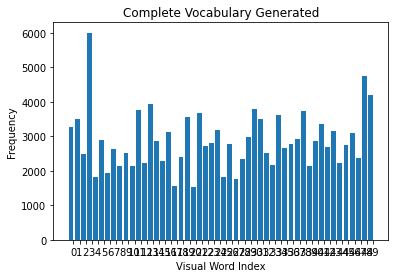

In [13]:
plot_hist(train_features)

### Training the model

In [14]:
from sklearn.preprocessing import StandardScaler
stdslr=StandardScaler().fit(train_features)

## Normalisation
train_features_norm=stdslr.transform(train_features)

## TF_IDF
# train_features_norm = TF_IDF(train_features)

from sklearn.svm import LinearSVC
clf_norm=LinearSVC(max_iter=80000)
clf_norm.fit(train_features_norm,np.array(y_train))
clf=LinearSVC(max_iter=80000)
clf.fit(train_features,np.array(y_train))

LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=80000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

/home/ksvsc/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1, max_iter=80000)

### Predicting the classes for test data

In [15]:
des_list_test=[]
for image_pat in image_paths_test:
    im=cv2.imread(image_pat)
    image = cv2.resize(im, (150,150), interpolation = cv2.INTER_AREA)
    descriptor_test = dsift(image,step_size)
    des_list_test.append((image_pat,descriptor_test))
    

test_features=np.zeros((len(image_paths_test),k),"float32")
for i in range(len(image_paths_test)):
    words,distance=vq(des_list_test[i][1],voc)
    for w in words:
        test_features[i][w]+=1

### ### Training images as histogram

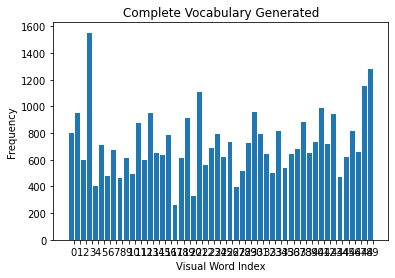

In [16]:
plot_hist(test_features)

## Normalise Histogram
test_features_norm=stdslr.transform(test_features)

##TF_IDF
# test_features_norm = TF_IDF(test_features)

In [17]:
true_classes=[]
for i in y_test:
    if i==0:
        true_classes.append("highway")
    elif i==1:
        true_classes.append("windmill")
    elif i==2:
        true_classes.append("waterfall")
    elif i==3:
        true_classes.append("laundromat")
    elif i==4:
        true_classes.append("park")
    elif i==5:
        true_classes.append("desert")
    elif i==6:
        true_classes.append("aquarium")
    elif i==7:
        true_classes.append("kitchen")

In [18]:
predict_classes=[]
for i in clf.predict(test_features):
    if i==0:
        predict_classes.append("highway")
    elif i==1:
        predict_classes.append("windmill")
    elif i==2:
        predict_classes.append("waterfall")
    elif i==3:
        predict_classes.append("laundromat")
    elif i==4:
        predict_classes.append("park")
    elif i==5:
        predict_classes.append("desert")
    elif i==6:
        predict_classes.append("aquarium")
    elif i==7:
        predict_classes.append("kitchen")
        
predict_classes_norm=[]
for i in clf_norm.predict(test_features_norm):
    if i==0:
        predict_classes_norm.append("highway")
    elif i==1:
        predict_classes_norm.append("windmill")
    elif i==2:
        predict_classes_norm.append("waterfall")
    elif i==3:
        predict_classes_norm.append("laundromat")
    elif i==4:
        predict_classes_norm.append("park")
    elif i==5:
        predict_classes_norm.append("desert")
    elif i==6:
        predict_classes_norm.append("aquarium")
    elif i==7:
        predict_classes_norm.append("kitchen")

In [19]:
crct_classified = []
wrong_classified = []
for i in range(0,len(true_classes),2):
    if len(crct_classified) >= 4 & len(wrong_classified)>= 4: 
        break
    elif len(wrong_classified)<4:
        if true_classes[i] != predict_classes_norm[i]:
            wrong_classified.append((image_paths_test[i],true_classes[i],predict_classes_norm[i]))
    elif len(crct_classified)<4:
        if true_classes[i] == predict_classes_norm[i]:
            crct_classified.append((image_paths_test[i],true_classes[i],predict_classes_norm[i]))

### Correctly Classified Images

Actual Class- highway
Predicted Class highway


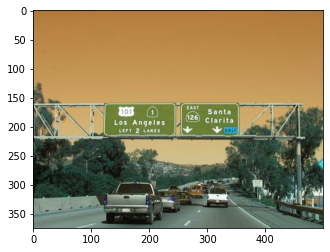

Actual Class- windmill
Predicted Class windmill


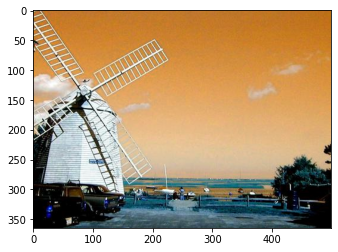

Actual Class- windmill
Predicted Class windmill


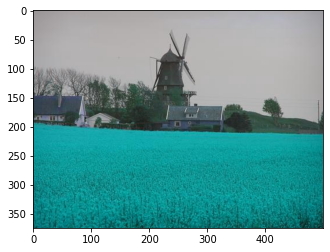

Actual Class- windmill
Predicted Class windmill


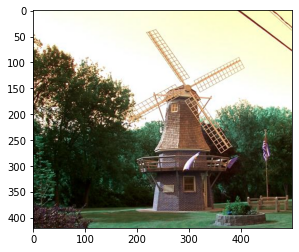

In [20]:
for im_path in crct_classified:
    im=cv2.imread(im_path[0])
    print("Actual Class-",im_path[1])
    print("Predicted Class",im_path[2])
    plt.imshow(im)
    plt.show()

### Wrongly Classified Images

Actual Class- highway
Predicted Class windmill


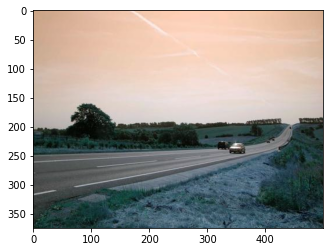

Actual Class- highway
Predicted Class windmill


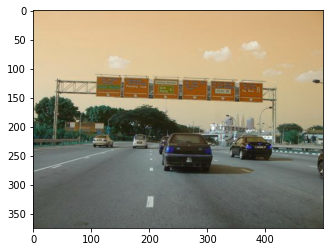

Actual Class- highway
Predicted Class desert


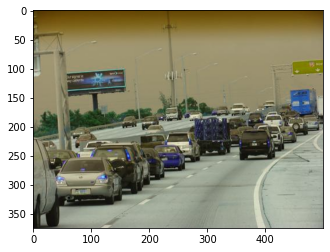

Actual Class- highway
Predicted Class desert


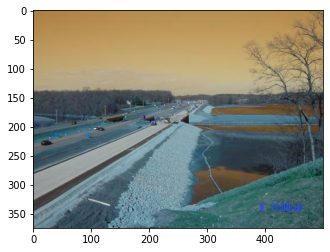

In [21]:
for im_path in wrong_classified:
    im=cv2.imread(im_path[0])
    print("Actual Class-",im_path[1])
    print("Predicted Class",im_path[2])
    plt.imshow(im)
    plt.show()

### Calculating Accuracy and Confusion matrix Plot

In [22]:
clf_norm.predict(test_features_norm)
clf.predict(test_features)
accuracy=accuracy_score(true_classes,predict_classes)
print("the accuracy of BoW without normalisation is",accuracy*100)

accuracy=accuracy_score(true_classes,predict_classes_norm)
print("the accuracy of BoW with normalisation is",accuracy*100)


from sklearn.metrics import confusion_matrix
cnf = confusion_matrix(true_classes, predict_classes)
cnf_norm = confusion_matrix(true_classes, predict_classes_norm)

the accuracy of BoW without normalisation is 50.625
the accuracy of BoW with normalisation is 50.625


confusion matrix without normalization


<AxesSubplot:>

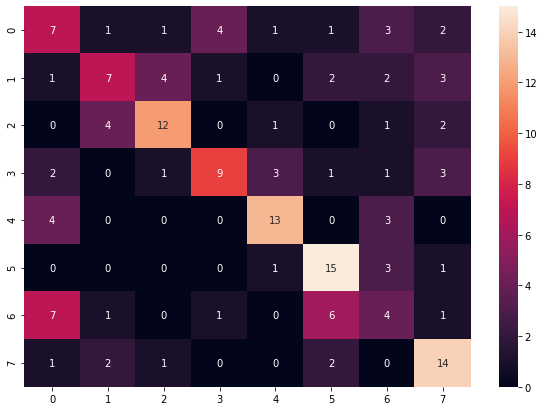

In [23]:
import seaborn as sn
import pandas as pd
print("confusion matrix without normalization")
df_cm = pd.DataFrame(cnf, index = [i for i in range(8)],columns = [i for i in range(8)])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

confusion matrix with normalization


<AxesSubplot:>

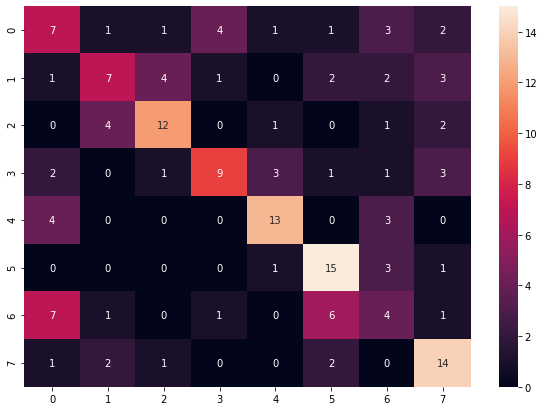

In [24]:
print("confusion matrix with normalization")
df_cm = pd.DataFrame(cnf_norm, index = [i for i in range(8)],columns = [i for i in range(8)])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

## Experiments

## Varying Step size in SIFT
1. **step size = 5**, Accuracy with normalization - 33.75 , Accuracy without normalization - 33.75
2. **step size = 10**, Accuracy with normalization - 49.375 , Accuracy without normalization - 49.75
3. **step size = 15**, Accuracy with normalization - 47.5 , Accuracy without normalization - 48.75
4. **step size = 20**, Accuracy with normalization - 42.5 , Accuracy without normalization - 42.625

#### Observation
As we decrease the steps size in dense sift computation, the accuracy increases. The reason for this could be that as we are decreasing the window for dense sift, the extracted features are more accurate. Thus, improving the classification accuracy.

## Varying Regularization Parameter
2. **C = 3**, Accuracy with normalization - 40.625 , Accuracy without normalization - 40.675
3. **C = 5**, Accuracy with normalization - 45.625 , Accuracy without normalization - 45.75
4. **C = 10**, Accuracy with normalization - 46.875 , Accuracy without normalization - 47.75
5. **C = 20**, Accuracy with normalization - 53.125 , Accuracy without normalization - 53.75

#### Observation
As we increase the regularization parameter, the accuracy increases. A high regularization parameter overcomes the overfitting, thus, improving the performance of the model.

## Varying Cluster Size
1. **Cluster size = 2=3**, Accuracy with normalization - 12.875 , Accuracy without normalization - 13.25
2. **Cluster size = 2=10**, Accuracy with normalization - 46.25 , Accuracy without normalization - 46.25
3. **Cluster size = 2=20**, Accuracy with normalization - 46.75 , Accuracy without normalization - 46.125
4. **Cluster size = 2=30**, Accuracy with normalization - 49.75 , Accuracy without normalization - 48.5
5. **Cluster size = 2=50**, Accuracy with normalization - 48.75 , Accuracy without normalization - 53.125

#### Observation
With an increase in no. of cluster, the accuracy increases. This is because when there are more clusters each cluster is well-defined to effectively classify the images.